In [1]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
#import sklearn
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## PA7 R3 Campaign and Nova data Merge and cleaning

In [2]:
df = pd.read_csv('combined.csv',  skiprows=range(0,3625)) # 3626 changes in combined column names
df1 = pd.read_csv('combined.csv',  skiprows= range(3625,30000)) # begging of combined older values

In [3]:
a = set(df1.columns.to_list())
b = set(df.columns.to_list())
to_drop = list(a-b)

In [4]:
df_ = pd.concat([df1.drop(columns=to_drop), df]) #combine messy data

In [5]:
df_ = df_.drop_duplicates()
df_ =df_ .dropna(axis=0, thresh=2) # get rid of useless rows

In [6]:
'Date & Time'

cols = ['Sample ID', 'pH', 'PO2', 'PCO2', 'Gln', 'Glu', 'Gluc',
       'Lac', 'NH4+', 'Na+', 'K+', 'Ca++','Osmolality',
       'Total Density', 'Viable Density', 'Viability', 'Avg. Live Diameter',
       'Cell Inspection Type', 'Vessel ID','Vessel Temperature (oC)', 'Vessel Pressure (psi)',
       'PO2 @ Temp', 'PCO2 @ Temp', 'O2 Saturation',
       'CO2 Saturation', 'HCO3','Batch ID','Date & Time']

In [7]:
df_p = df_[cols].dropna(subset=['Viability'])

In [8]:
df_p.rename(columns={'Batch ID':"Process Lot"}, inplace=True) # for join later
df_p['Process Lot'] = pd.to_numeric(df_p['Process Lot'], errors='coerce', downcast='integer')
df_p = df_p.dropna(subset=['Process Lot'])

In [9]:
test = df_p.copy()

### convert most columns to numeric for later processing
dropped ph @ temp due to extreme small values, and pH alone should be good enough

In [10]:
cols = ['pH', 'PO2', 'PCO2', 'Gln', 'Glu', 'Gluc',
       'Lac', 'NH4+', 'Na+', 'K+', 'Ca++','Osmolality',
       'Total Density', 'Viable Density', 'Viability', 'Avg. Live Diameter',
        'Vessel ID','Vessel Temperature (oC)', 'Vessel Pressure (psi)',
       'PO2 @ Temp', 'PCO2 @ Temp', 'O2 Saturation',
       'CO2 Saturation', 'HCO3',]

In [11]:
test[cols] = test[cols].apply(pd.to_numeric, errors='coerce')
test = test.fillna(test.mean())

<ipython-input-11-872fbd6913bb>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test = test.fillna(test.mean())


In [12]:
PA7_3K = pd.read_csv('PA7_data_tracker.csv')

lots_a = set(PA7_3K['Process Lot'].to_list())
lots_b = set(test['Process Lot'].to_list())

lots_to_keep = lots_a.intersection(lots_b)

In [13]:
inoc_dict = dict(zip(PA7_3K['Process Lot'], PA7_3K['dummy'])) # for getting inoc start/end times for each lot
final_df = test[test['Process Lot'].isin(lots_to_keep)]
final_df['inoc_time']  = final_df['Process Lot'].replace(inoc_dict) 

<ipython-input-13-8250e2c7775c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['inoc_time']  = final_df['Process Lot'].replace(inoc_dict)


In [14]:
# test[test['Process Lot'] == 8044300268]

In [15]:
throw_away_lots = list(final_df[final_df['inoc_time'].isnull()]['Process Lot'].unique()) # 12 numbers for lot numbers
final_df = final_df[~final_df['Process Lot'].isin(throw_away_lots)]

### 58 Production Lots (PA7 R3)

In [16]:
len(final_df['Process Lot'].unique())

58

### correct inoc time for errant Lot 8044300344

In [17]:
final_df.reset_index(inplace=True)
idxs = list(final_df[final_df['Process Lot'] == 8044300344 ].index)
final_df.iloc[[idxs], [-1]] = '2019-10-26 09:25:00'

In [18]:
final_df['Date & Time'] = pd.to_datetime(final_df['Date & Time'])
final_df['inoc_time'] = pd.to_datetime(final_df['inoc_time'])

### Cell Culture duration calculation

In [19]:
final_df['CC_duration'] = final_df['Date & Time'] - final_df['inoc_time']
final_df['duration'] = final_df['CC_duration'] / np.timedelta64(1, 'h')

### REGN668 R3 IM: 80443

In [20]:
final_df = final_df[final_df['Process Lot'].astype(str).str[0:5].eq('80443')]

In [21]:
final_df.rename(columns={"Process Lot":'Process_lot',
                        'Viable Density':'VCD'}, inplace=True) 

In [22]:
final_df.drop(columns=['CC_duration'],inplace=True)

In [23]:

chart = alt.Chart(final_df).mark_circle(size=60).encode(
    alt.X('duration', title='Cell Culture Duration (Hrs)'),
    alt.Y('VCD',title='Viable Cell Density x 10 ^5'),
    color= 'Process_lot:N',
    tooltip = ['Process_lot', 'VCD', 'duration']

).properties(
    width=840,
    height=400,
    title='PA7 R3 668 Historical VCD Growth'
)


# chart.interactive()

## Drop errant value

In [24]:
final_df.drop(axis=0, index=206, inplace=True)

In [25]:
# issue with duration 8044300344

df = pd.DataFrame({
    'x': [44.57, 68.7, 44.57, 68.7],
    'y': [33.08, 33.08,  42.04, 42.04],
    'class': ['A', 'A','B', 'B']
})


a = alt.Chart(df).mark_line(color='red', strokeDash=[3,5]).encode(
    x='x',
    y='y',
    detail='class'
)

# (chart+a).interactive()

## Evaluating Feature Importance via Mutual information

In [26]:
# df = df.apply(pd.to_numeric, errors='coerce')

In [27]:
X = final_df.copy().select_dtypes(np.number)
y = X.pop("VCD") # label
X.pop('PO2 @ Temp') # inf values
X.pop('PCO2 @ Temp')


0      72.6
1      53.9
2      24.2
3      24.2
4      63.0
       ... 
221    75.9
222    49.6
223    20.5
224    21.1
225    23.3
Name: PCO2 @ Temp, Length: 225, dtype: float64

In [28]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y)
mi_scores[::3]  # show a few features with their MI scores

Total Density    3.824914
HCO3             1.263460
NH4+             1.120099
PO2              0.710171
Gln              0.389724
Glu              0.243953
Process_lot      0.162001
Vessel ID        0.004013
Name: MI Scores, dtype: float64

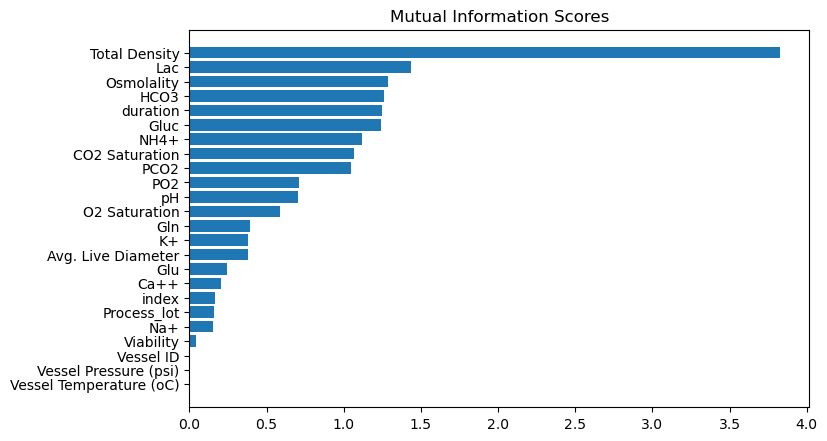

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_mi_scores(scores):
    import matplotlib.pyplot as plt
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

### Remove data leakage variable (Total Density)

In [30]:
X.columns

Index(['index', 'pH', 'PO2', 'PCO2', 'Gln', 'Glu', 'Gluc', 'Lac', 'NH4+',
       'Na+', 'K+', 'Ca++', 'Osmolality', 'Total Density', 'Viability',
       'Avg. Live Diameter', 'Vessel ID', 'Vessel Temperature (oC)',
       'Vessel Pressure (psi)', 'O2 Saturation', 'CO2 Saturation', 'HCO3',
       'Process_lot', 'duration'],
      dtype='object')

In [31]:
X = final_df.copy().select_dtypes(np.number).drop(columns='Total Density')
y = X.pop("VCD")
X.pop('PCO2 @ Temp')
X.pop('PO2 @ Temp')
mi_scores = make_mi_scores(X, y)

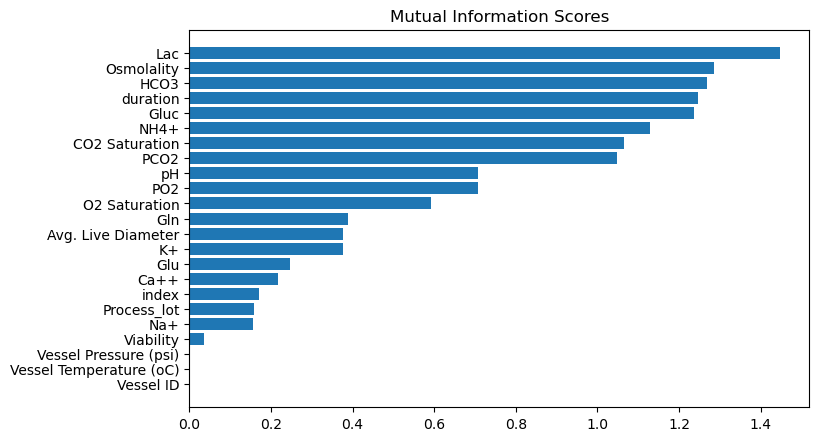

In [32]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [33]:
mi_scores[0:10]

Lac               1.446996
Osmolality        1.284921
HCO3              1.267450
duration          1.246421
Gluc              1.236459
NH4+              1.128837
CO2 Saturation    1.066296
PCO2              1.047710
pH                0.708126
PO2               0.707430
Name: MI Scores, dtype: float64

In [34]:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [35]:
def boost_regress():
    from sklearn.ensemble import GradientBoostingClassifier
    results = []
    #for i in range(1,11):

    clf = GradientBoostingRegressor(random_state=0,).fit(X_train, y_train)

    results = (clf.score(X_train, y_train), clf.score(X_test, y_test))
    return results

In [36]:
boost_regress()

(0.999099071319468, 0.9644150281715027)

In [37]:
clf = GradientBoostingRegressor(random_state=0,).fit(X_train, y_train)

clf.predict(X_test)

array([31.17647383, 37.70781621,  5.16027468, 22.44367908, 18.50163622,
        6.0940411 , 27.73909024, 14.92385137, 44.30742798,  5.62107246,
       35.84021674, 17.70964501, 31.50726306,  6.30512919, 34.09807129,
       13.62188069, 41.07353107, 15.3803172 , 16.90617661, 37.1123064 ,
       34.8820506 , 27.28538896, 26.03539589, 35.61301185, 16.35676696,
        7.4256426 , 39.42227979, 32.80685678, 17.90378361,  5.78250624,
       12.17766902, 31.10534678, 32.63381963, 15.24396344, 18.31214238,
        6.28741529,  6.47467251, 28.87491528, 36.15892629, 36.06454202,
       23.55989155, 30.05737793,  6.93459555, 17.33720707, 30.23377388,
       39.37667527,  7.03697822, 29.29488301, 45.75676596, 38.71318198,
        5.35985967, 16.3179515 ,  5.72164978,  6.60794525, 14.77267363,
       16.72904332, 33.56772146])

### Organizing Predicted vs Actual VCD values For plotting

In [38]:
pred = pd.DataFrame({'type': 'predicted',
                    "VCD":clf.predict(X_test),
                    'duration': X_test['duration']})
actual = pd.DataFrame({'type': 'actual',
                    "VCD":y_test,
                    'duration': X_test['duration']})

to_plot = pd.concat([pred,actual])
to_plot['Process_lot'] = X_test['Process_lot']

In [39]:
chart2 = alt.Chart(to_plot).mark_circle(size=60,).encode(
    alt.X('duration', title='Cell Culture Duration (Hrs)'),
    alt.Y('VCD',title='Viable Cell Density x 10 ^5'),
    color = 'type',
    tooltip = ["type", 'VCD', 'duration','Process_lot']

).properties(
    width=840,
    height=400,
    title='GradientBoostingRegressor Predictions vs actual'
).interactive()

In [40]:
chart2

alt.Chart(...)

### To do/ Issues with this approach so far
- Compare with cell doubling calculator
- Grid Search
- Test on other PA product combinations
- Test on other Bioreactors (R1, R2, R4)

### Other potential projects:
- Clustering poor/good performers (Production lots) to examine process parameters and indicators present with poor/good performers
- Predict Other process parameters (like Viabiltiy, Titer production etc.)

### Grid Search for hyperparameters

- try 3 fold CV
- MSE
- train on only target region

### for cell doubling time comparison

In [41]:
#cd_hack = to_plot[to_plot['duration'] >= 44.57]['duration'].to_list() # to only predict the times in test set
cd_hack = to_plot['duration'].to_list() # durations in test set

In [42]:
s = list(X_test['Process_lot'].unique())
#s = list(X_test[(X_test['duration'] >= (44.57)) & (X_test['duration'] <= (68.7)) ]['Process_lot'].unique())

In [43]:
#out = final_df[final_df['Process_lot'].isin(s)][['Process_lot', 'duration', 'VCD']]

In [44]:
# out.to_csv('out.csv')


In [45]:
cont = []
dur = []
lots = []
lac = []
final_df = final_df.sort_values(by='duration', ascending=True)
# final_df['dummy'] = final_df['duration'].isin(cd_hack).astype(int) for some reason won't work with df have to do each lot
# final_df['dummy'] = final_df['dummy'].shift(-1)
#final_df['dummy'] = (final_df['dummy'] ==1) and ()
for lot in s:
    temp = final_df.copy()
    temp = temp[temp['Process_lot']==lot][['Process_lot','duration', 'VCD','Lac']]
    #temp = temp.sort_values(by='duration', ascending=True)
    temp ['dummy'] = temp['duration'].isin(cd_hack).astype(int) # each lot to prevent spill over
    temp ['z'] = temp['dummy'].shift(-1)
    temp.reset_index(inplace=True)
    
    temp['duration'] = temp['duration']/24
    temp['VCD'] = np.log(temp['VCD'])
    for index, row in temp.iterrows():
        if row['z'] == 1 and index !=0: # first index points can't fit a regression only one point
            x = temp[['duration']].iloc[0:(index+1)]
            y= temp[['VCD']].iloc[0:(index+1)]
            #if row['Process_lot'] in ([8044300344,8044300320, 8044300309]):# debugging drop two points because makign prediction off only one point
            #   print(temp)
            reg = LinearRegression().fit(x,y)
            val = reg.predict(np.array(temp[['duration']].iloc[index+1]).reshape(-1, 1))
            dur.append(np.ravel(np.array(temp[['duration']].iloc[index+1]).reshape(-1, 1)).item()*24)
            cont.append(np.ravel(np.exp(val)).item())
            lots.append(temp['Process_lot'].iloc[index])
            lac.append(temp['Lac'].iloc[index])
    
# validated with excel spreadsheet doubling calculator

In [46]:
cd_spread = pd.DataFrame({'type': 'cd_calculator',
                    "VCD":cont,
                    'duration': dur,
                    'Process_lot': lots,
                         })
cd_spread['dummy'] = cd_spread['duration'].isin(cd_hack).astype(int)
to_plot_all = pd.concat([to_plot, cd_spread])
# to_plot['Process_lot'] = X_test['Process_lot']

In [47]:
test_plot = to_plot_all[to_plot_all['duration'].isin(cd_hack)]


In [48]:
chart3 = alt.Chart(to_plot_all[~((to_plot_all['duration'] < 30) &  (to_plot_all['type'] =='cd_calculator'))]).mark_circle(size=60,).encode(
    alt.X('duration', title='Cell Culture Duration (Hrs)'),
    alt.Y('VCD',title='Viable Cell Density x 10 ^5'),
    color = 'type',
    tooltip = ["type", 'VCD', 'duration','Process_lot']

).properties(
    width=840,
    height=400,
    title='GradientBoostingRegressor vs Cell Doubling Time'
)
sav = (chart3 ).interactive()

sav

alt.Chart(...)

In [49]:
#sav.save('chart.html')

### need at least 2 data points to generate a prediction for CD calculator

In [50]:
from sklearn.metrics import mean_squared_error
expansion_window = to_plot_all[to_plot_all['duration'] >= 43.8].sort_values(by='duration')

In [51]:
true = expansion_window[expansion_window['type'] == 'actual']['VCD'].to_list()
GB_pred = expansion_window[expansion_window['type'] == 'predicted']['VCD'].to_list()
CD_pred = expansion_window[expansion_window['type'] == 'cd_calculator']['VCD'].to_list()

In [52]:
mean_squared_error(true, GB_pred)

5.364085341751179

In [53]:
mean_squared_error(true, CD_pred) # need to sort

20.520586201698414

In [54]:
final_df.columns

Index(['index', 'Sample ID', 'pH', 'PO2', 'PCO2', 'Gln', 'Glu', 'Gluc', 'Lac',
       'NH4+', 'Na+', 'K+', 'Ca++', 'Osmolality', 'Total Density', 'VCD',
       'Viability', 'Avg. Live Diameter', 'Cell Inspection Type', 'Vessel ID',
       'Vessel Temperature (oC)', 'Vessel Pressure (psi)', 'PO2 @ Temp',
       'PCO2 @ Temp', 'O2 Saturation', 'CO2 Saturation', 'HCO3', 'Process_lot',
       'Date & Time', 'inoc_time', 'duration'],
      dtype='object')

In [55]:
cols_ins= ['pH', 'PO2', 'PCO2', 'Gln', 'Glu', 'Gluc', 'Lac',
       'NH4+', 'Na+', 'K+', 'Ca++', 'Osmolality','duration', 'Process_lot']

In [56]:
final_df['Process_lot'] = final_df['Process_lot'].astype(str)

In [57]:
final_df.sort_values(['Process_lot','duration'])[cols_ins]

,pH,PO2,PCO2,Gln,Glu,Gluc,Lac,NH4+,Na+,K+,Ca++,Osmolality,duration,Process_lot
0,7.207,162.7,74.2,2.18,3.04,5.76,0.55,0.58,69.4,10.51,0.52,295.0,0.237778,8044300219.0
1,7.153,142.3,55.1,1.78,3.03,4.80,1.32,1.24,68.9,10.16,0.50,288.0,24.195000,8044300219.0
2,7.029,107.5,24.8,1.38,3.19,3.27,2.11,1.60,69.5,9.88,0.48,280.0,43.956389,8044300219.0
3,6.891,99.5,24.7,1.21,3.23,2.75,2.60,1.64,70.5,9.94,0.48,274.0,53.701389,8044300219.0
4,7.238,164.6,64.4,2.41,2.91,5.78,0.46,0.58,66.8,9.92,0.48,294.0,0.304722,8044300226.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,7.171,163.7,77.5,1.95,3.34,5.88,0.34,0.56,71.8,10.28,0.48,297.0,0.411944,8044300567.0
222,7.223,158.0,50.7,1.66,3.37,5.16,0.90,1.23,71.9,10.11,0.55,287.0,24.759444,8044300567.0
223,7.191,148.9,21.0,1.25,3.52,4.03,1.94,1.71,71.6,9.89,0.42,280.0,45.937778,8044300567.0
224,6.970,128.4,21.5,1.05,3.51,3.22,2.45,1.83,72.6,9.68,0.42,276.0,57.550000,8044300567.0


## Using only duration and LAC

In [58]:
def boost_regress():
    from sklearn.ensemble import GradientBoostingClassifier
    results = []
    #for i in range(1,11):

    clf = GradientBoostingRegressor(random_state=0,).fit(X_train[['Lac','duration']], y_train)

    results = (clf.score(X_train[['Lac','duration']], y_train), clf.score(X_test[['Lac','duration']], y_test))
    return results

In [59]:
boost_regress()

(0.9936748744139627, 0.9514366049947393)

In [60]:
clf_x = GradientBoostingRegressor(random_state=0,).fit(X_train[['Lac','duration']], y_train)

In [61]:
pred_x = pd.DataFrame({'type': 'predicted',
                    "VCD":clf_x.predict(X_test[['Lac','duration']]),
                    'duration': X_test['duration']})
actual_x = pd.DataFrame({'type': 'actual',
                    "VCD":y_test,
                    'duration': X_test['duration']})

to_plot_x = pd.concat([pred_x,actual_x, cd_spread])
to_plot_x['Process_lot'] = X_test['Process_lot']

In [62]:
true_x = to_plot_x[to_plot_x['type'] == 'actual']['VCD'].to_list()
GB_pred_x = to_plot_x[to_plot_x['type'] == 'predicted']['VCD'].to_list()


In [63]:
mean_squared_error(true_x, GB_pred_x)

7.635161105415804

### comparing with multifeature GB 

In [64]:
expansion_window = to_plot_all[to_plot_all['duration'] >= 0].sort_values(by='duration')
true = expansion_window[expansion_window['type'] == 'actual']['VCD'].to_list()
GB_pred = expansion_window[expansion_window['type'] == 'predicted']['VCD'].to_list()

In [65]:
mean_squared_error(true, GB_pred)

5.594686961503142

In [66]:
chart3 = alt.Chart(to_plot_x).mark_circle(size=60,).encode(
    alt.X('duration', title='Cell Culture Duration (Hrs)'),
    alt.Y('VCD',title='Viable Cell Density x 10 ^5'),
    color = 'type',
    tooltip = ["type", 'VCD', 'duration','Process_lot']

).properties(
    width=840,
    height=400,
    title='GradientBoostingRegressor [Dur, LAC] vs Cell Doubling Time'
)
sav = (chart3 ).interactive()

sav

alt.Chart(...)

In [67]:
import random

In [68]:
X_test[['Lac','duration']].iloc[random.randint(0, len(X_test))].to_list()

[1.06, 23.733055555555556]

In [69]:
clf_x.predict(np.array([1.23, 60.03611111111111]).reshape(1,-1))

array([37.62996598])

In [70]:
clf_x.predict?

In [71]:
np.array([1.23, 60.03611111111111]) + (0,24)

array([ 1.23      , 84.03611111])

In [72]:
shifted_24 = X_test[['Lac','duration']]  + (0,24)

In [73]:
mean_squared_error(clf_x.predict(shifted_24), y_test)

198.72633689186938

### focusing on duration window

In [74]:
expansion_window_x = to_plot_all[to_plot_all['duration'] >= 32].sort_values(by='duration')

In [75]:
df_re = expansion_window_x[expansion_window_x['type'] == 'actual']

In [76]:
df_re = df_re.merge(final_df[['duration', 'Lac']], on='duration')

In [77]:
mean_squared_error(clf_x.predict(df_re[['Lac','duration']] +(0,24)), df_re['VCD'])

253.1641753345706

In [78]:
pred_x = pd.DataFrame({'type': 'predicted',
                    "VCD":clf_x.predict(X_test[['Lac','duration']]),
                    'duration': X_test['duration'],
                      })
actual_x = pd.DataFrame({'type': 'actual',
                    "VCD":y_test,
                    'duration': X_test['duration']})

shifted = pd.DataFrame({'type': 'shifted',
                    "VCD": clf_x.predict(shifted_24),
                    'duration': X_test['duration']})


to_plot_x = pd.concat([pred_x,actual_x,shifted])
to_plot_x['Process_lot'] = X_test['Process_lot']

In [79]:
chart3 = alt.Chart(to_plot_x).mark_circle(size=60,).encode(
    alt.X('duration', title='Cell Culture Duration (Hrs)'),
    alt.Y('VCD',title='Viable Cell Density x 10 ^5'),
    color = 'type',
    tooltip = ["type", 'VCD', 'duration','Process_lot']

).properties(
    width=840,
    height=400,
    title='GradientBoostingRegressor [Dur, LAC] Shifting 24hrs'
)
sav = (chart3 ).interactive()

sav

alt.Chart(...)

# Training regressor with shifted data

### shifting stategy to create training dataset

In [80]:

dfs = []
final_df = final_df.sort_values(by='duration', ascending=True)

for lot in final_df['Process_lot'].unique():
    temp = final_df.copy()
    temp = temp[temp['Process_lot']==lot]
    temp['VCD'] = temp['VCD'].shift(1)

    temp.reset_index(inplace=True)
    
    dfs.append(temp)
    
shifted_df = pd.concat(dfs)

In [81]:
X = shifted_df.copy().select_dtypes(np.number).drop(columns='Total Density')
X.dropna(axis=0,inplace=True)
y = X.pop("VCD")
X.pop('PCO2 @ Temp')
X.pop('PO2 @ Temp')
X.pop('index')
X['Process_lot'] = final_df['Process_lot']
X.dropna(axis=0, inplace=True)
y = y.dropna()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [82]:
def boost_regress():
    from sklearn.ensemble import GradientBoostingClassifier
    results = []
    #for i in range(1,11):

    clf = GradientBoostingRegressor(random_state=0,).fit(X_train, y_train)

    results = (clf.score(X_train, y_train), clf.score(X_test, y_test))
    return results

In [83]:
boost_regress()

(0.9976444338564897, 0.7824947630158635)

In [84]:
clf_x = GradientBoostingRegressor(random_state=0,).fit(X_train, y_train)

In [85]:
pred_x = pd.DataFrame({'type': 'predicted',
                    "VCD":clf_x.predict(X_test),
                    'duration': X_test['duration'],
                       'Process_lot': X_test['Process_lot']
                      })
actual_x = pd.DataFrame({'type': 'actual',
                    "VCD":y_test,
                    'duration': X_test['duration'],
                        'Process_lot': X_test['Process_lot']})


to_plot_x = pd.concat([pred_x,actual_x])
#to_plot_x['Process_lot'] = X_test['Process_lot']

In [86]:
to_plot_x

,type,VCD,duration,Process_lot
1,predicted,5.590323,24.708889,8044300219.0
2,predicted,23.051778,55.175833,8044300219.0
2,predicted,18.175574,43.181944,8044300219.0
4,predicted,25.137448,46.168611,8044300226.0
1,predicted,5.339526,23.305278,8044300219.0
...,...,...,...,...
1,actual,5.960000,21.846667,8044300219.0
1,actual,6.160000,23.176111,8044300219.0
2,actual,20.150000,43.083611,8044300219.0
1,actual,5.220000,23.088889,8044300219.0


In [87]:
chart3 = alt.Chart(to_plot_x).mark_circle(size=60,).encode(
    alt.X('duration', title='Cell Culture Duration (Hrs)'),
    alt.Y('VCD',title='Viable Cell Density x 10 ^5'),
    color = 'type',
    tooltip = ["type", 'VCD', 'duration', 'Process_lot']

).properties(
    width=840,
    height=400,
    title='GradientBoostingRegressor Shifting'
)
sav = (chart3 ).interactive()

sav

alt.Chart(...)

In [88]:
features = mi_scores.index[0:8].to_list()
features.append('Process_lot')

In [90]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y)
mi_scores[::3]  # show a few features with their MI scores

duration                 0.880069
NH4+                     0.724325
Gluc                     0.652551
PO2                      0.424547
Gln                      0.254012
level_0                  0.158730
Ca++                     0.064373
Vessel Pressure (psi)    0.000000
Name: MI Scores, dtype: float64

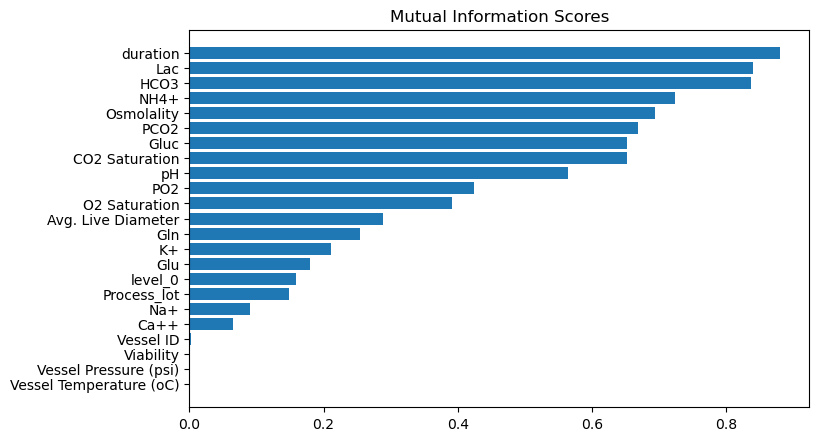

In [91]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_mi_scores(scores):
    import matplotlib.pyplot as plt
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [92]:
mean_squared_error(clf_x.predict(X_test), y_test)

20.161392620195652